In [1]:
from cosmoslik import *

In [2]:
chain=load_chain("LBAOSN.chain")

In [3]:
print(chain)

     # of chains:  2
      # of steps:  21900
    total weight:  70571.00
      acceptance:  0.31
              H0:       73.51 ± 1.637
        alphaBAO:      0.2968 ± 0.00367
         alphaSN:      0.3644 ± 0.00168
              wm:      0.2975 ± 0.02011


/nfs/home/mjoy/myVE/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


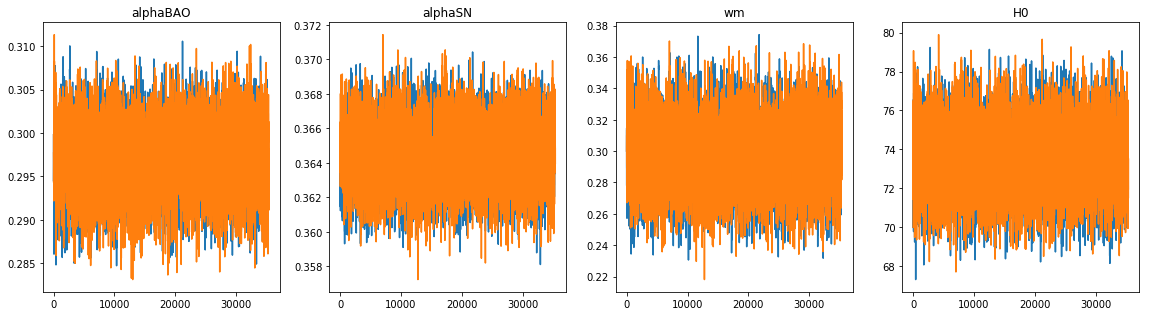

In [5]:
chain.plot()

In [6]:
chain=chain.burnin(15000).join()

In [8]:
chain.best_fit()

{'H0': 73.64043327659304,
 'alphaBAO': 0.2964496682703614,
 'alphaSN': 0.3642873703132782,
 'lnl': 25.532109548543495,
 'rs': 137.32965363998434,
 'weight': 4.0,
 'wm': 0.29697794403171784}

In [7]:
#2*25.555281975831196

In [8]:
#chain.savecov("cov_LBAOSN_LCDM.txt")

In [7]:
chain['rs']=2.998e05/(chain['H0']*chain['alphaBAO']*100)
#print(chain)

In [10]:
#chain.likegrid()

In [11]:
c=2.998e8
chain['lsn']=c/1000/chain['H0']/(chain['alphaSN']*10000)
#print(chain)

In [12]:
chain.best_fit()

{'H0': 73.64043327659304,
 'alphaBAO': 0.2964496682703614,
 'alphaSN': 0.3642873703132782,
 'lnl': 25.532109548543495,
 'lsn': 1.1175608484654913,
 'rs': 137.32965363998434,
 'weight': 4.0,
 'wm': 0.29697794403171784}

In [13]:
from cosmoslik import *
import numpy as np
import scipy as sp
from scipy.integrate import quad
from scipy.interpolate import *

k=8.62*10**(-5) #Boltzmann constant (eV/K)
hp=4.136*10**(-15) #Planck constant (eV*s)
Tg=2.73 #CMB photon temperature (K)
c=2.998e8 #speed of light (m/s)
mn=0.02/(c**2) #neutrino mass (eV/c^2)
L=mn*c**2/(k*Tg*(4/11)**(1/3))
h=0.72 #hubble
p0=1.88*h**2*10**(-26)*1.783*10**36 #current critical energy density
wr=5*10**(-5) #radiation content
rfid=147.78 #fiducial value of sound horizon (Mpc)

In [14]:
alphaBAO=0.2964496682703614
alphaSN=0.3642873703132782
rs=137.32965363998434
H0=73.64043327659304
wm=0.29697794403171784

In [15]:
def wn(z): #neutrino energy density
    def n_integrand(x,z):
        return x**2*np.sqrt((1/(1+z))**2+x**2)/(np.exp(x*L)+1)
    n=quad(n_integrand,0,np.inf,args=(z))
    return n[0]*((3*c**5*mn**4)*(1/(1+z))**(-4)*p0**(-1)*(np.pi)**(-2)*hp**(-3))
zgrid=np.arange(.01,1,.01)
wngrid=[]
for i in range(len(zgrid)):
    wngrid=np.append(wngrid,wn(zgrid[i]))
wn_cs=sp.interpolate.CubicSpline(zgrid,wngrid) #spline interpolation of wn for faster code
z=[0.38,0.51,0.61]
DzHdata=np.array([1512.39,81.2087,1975.22,90.9029,2306.68,98.9647]) #alternating DA and 
                                                                            #H(z) for BAO data
be=np.loadtxt("BAO_consensus_covtot_dM_Hz.txt")
C_BAO=np.array(be) #BAO covariance matrix
        
md=np.array([])
def integrand(x,wm,wr,wn_cs):
    return 1/(np.sqrt(wm*x+(1-wm)*x**4+wr+wn_cs((1/x)-1)))
i=0
while i<3:
    a=1/(1+z[i])
    Dz=quad(integrand,1/(1+z[i]),1,args=(wm,wr,wn_cs))[0]*alphaBAO*100*rfid #ang.diam.dist
    H=c*(alphaBAO*100)**(-1)*rfid**(-1)*np.sqrt(wm*a**(-3)+(1-wm)+wr*a**(-4)+wn_cs(z[i]))/1000
    md=np.append(md,Dz)
    md=np.append(md,H)
    i=i+1
DzHmodel=np.array(md)

zdata=np.loadtxt("z_SN.txt") 
zdata=np.array(zdata)
mbdata=np.loadtxt("mb_SN.txt")
dmbdata=np.loadtxt("dmb_SN.txt")
        
Csys=np.loadtxt("SNe_Csys.txt")
Csys=np.array(Csys)
shape=(40,40)
Csys=Csys.reshape(shape) #systematic error covariance matrix
Cstat=np.zeros((40,40))
k=0
j=0
while k<40 and j<40:
    Cstat[k,j]=(dmbdata[k])**2 #statistical covariance matrix for SN data
    k=k+1
    j=j+1
C_SN=Cstat+Csys #supernovae covariance matrix
m=0
mbmodel=np.array([])
while m<40:
    DL=quad(integrand,1/(1+zdata[m]),1,args=(wm,wr,wn_cs))[0]*alphaSN*10000*(1+zdata[m])
    mb= -19 + 5*np.log10(DL) + 25
    mbmodel=np.append(mbmodel,mb)
    m=m+1
Mbmodel=np.array(mbmodel)

/nfs/home/mjoy/myVE/lib/python3.4/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
LBAO=0.5*(np.dot(DzHmodel-DzHdata,np.dot(np.linalg.inv(C_BAO),(DzHmodel-DzHdata))))
LSN=0.5*(np.dot(Mbmodel-mbdata,np.dot(np.linalg.inv(C_SN),(Mbmodel-mbdata))))

In [17]:
print(2*LSN)
print(2*LBAO)

39.31948952504082
3.5485347606071747
